# Overview

This notebook in intended as a generic notebook to be used with the papermill python library to allow automated generation of analyses and reports for classifiers on microbiome data generated by kraken2 pipeline

In [1]:
cd /project/src

/project/src


In [2]:
from sklearn import model_selection
from sklearn import metrics
import os
import re
import copy
import numpy as np
import pandas as pd
from MicroBiome import MicroBiomeDataSet, Trainer, TrainTester, MultiTrainTester, list_transformer, DiffExpTransform
from ScoreFunctions import *
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model as LM
import seaborn as sns
import pickle as pk
from matplotlib import pyplot as plt
# Ignore warning messages
if True:
    import warnings
    warnings.filterwarnings('ignore')

# Basic Data Loading

In [3]:
input_dir = '/project/data/preprocessed/PE_50K_sex_complete'
output_dir = '/project/results/LR_Classifier_clinical_only_generic'
retrain = True

In [4]:
os.listdir(input_dir)

['meta_data_mat.pk',
 'metadata_samples_keep.csv',
 'y.pk',
 'X.pk',
 'feat_meta.csv']

In [5]:
# infile_X = open(os.path.join(input_dir, 'X.pk'),'rb')
# X = pk.load(infile_X)
# infile_X.close()
infile_y = open(os.path.join(input_dir, 'y.pk'),'rb')
y = pk.load(infile_y)
infile_y.close()
infile_meta_data_mat = open(os.path.join(input_dir, 'meta_data_mat.pk'), 'rb')
meta_data_mat = pk.load(infile_meta_data_mat)
infile_meta_data_mat.close()
# model input
# X_inp = np.concatenate([X, meta_data_mat], axis=1)
X_inp = meta_data_mat

# Train Model

In [6]:
n_splits = 10
out_path = os.path.join(output_dir, 'MyMultiTrainTester.pk')

if retrain:
    # clear previous results, if any
    if os.path.exists(output_dir):
        os.system('rm -rf ' + output_dir)
    os.mkdir(output_dir)
    # model definition
    clf = LM.LogisticRegression(random_state=42, class_weight='balanced', 
                                penalty='l2', solver='liblinear')
    param_grid = dict(C=np.exp(-np.arange(-10, 10)))
    model=model_selection.GridSearchCV(clf, param_grid, scoring=metrics.make_scorer(metrics.f1_score), cv = 5)
    # Trainer
    MyTrainer = Trainer(model=model)
    # random seed used in class definition is not used in final output models
    MyTrainTester = TrainTester(MyTrainer, metrics.f1_score)
    # note that random seed here affects sequence of seeds passed to making new TrainTester objects
    # using LRTrainTester as template. Thus, you have all settings but seed affecting sample split
    # across all data splits
    MyMultiTrainTester = MultiTrainTester(MyTrainTester, numpy_rand_seed=42, n_splits=n_splits)
    MyMultiTrainTester.train(X_inp, y)
    # save results
    outfile = open(out_path,'wb')
    pk.dump(MyMultiTrainTester, outfile)
    outfile.close()
    
else:
    # load previous results
    infile = open(out_path,'rb')
    MyMultiTrainTester = pk.load(infile)
    infile.close()

Running for split 1 of 10
Using predict_proba
getting predictions from probs
Running for split 2 of 10
Using predict_proba
getting predictions from probs
Running for split 3 of 10
Using predict_proba
getting predictions from probs
Running for split 4 of 10
Using predict_proba
getting predictions from probs
Running for split 5 of 10
Using predict_proba
getting predictions from probs
Running for split 6 of 10
Using predict_proba
getting predictions from probs
Running for split 7 of 10
Using predict_proba
getting predictions from probs
Running for split 8 of 10
Using predict_proba
getting predictions from probs
Running for split 9 of 10
Using predict_proba
getting predictions from probs
Running for split 10 of 10
Using predict_proba
getting predictions from probs


In [7]:
scores_df = pd.DataFrame({'score': MyMultiTrainTester.train_scores, 'stage' : np.repeat('train', n_splits)})
scores_df = scores_df.append(pd.DataFrame({'score': MyMultiTrainTester.test_scores, 'stage' : np.repeat('test', n_splits)}))
scores_df

,score,stage
0,0.726225,train
1,0.742029,train
2,0.727273,train
3,0.719764,train
4,0.710059,train
5,0.710059,train
6,0.743662,train
7,0.686930,train
8,0.718841,train
9,0.731429,train


<AxesSubplot:xlabel='stage', ylabel='score'>

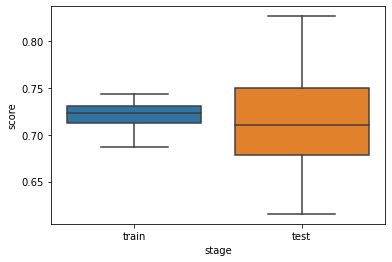

In [8]:
sns.boxplot(data = scores_df, x = 'stage', y = 'score')

In [9]:
# hyperparams = {'l1_ratio': [], 'C': []}
feats_in_split = []
hyperparams = {'C': []}
for i in range(n_splits):
    hyperparams['C'].append(MyMultiTrainTester.TrainerList[i].model.best_params_['C'])
hyperparams_df = pd.DataFrame(hyperparams)
hyperparams_df

,C
0,22026.465795
1,22026.465795
2,22026.465795
3,22026.465795
4,22026.465795
5,22026.465795
6,22026.465795
7,22026.465795
8,22026.465795
9,22026.465795


<AxesSubplot:xlabel='score_type', ylabel='value'>

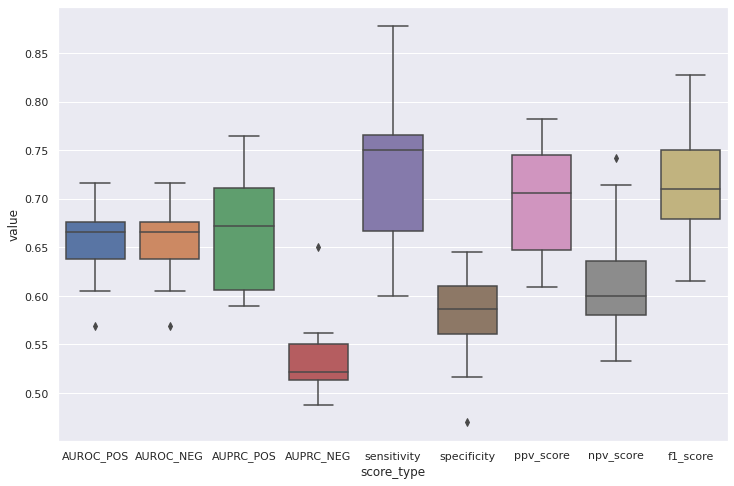

In [10]:
scoring_metrics = MyMultiTrainTester.getScores()
scoring_metrics_df = pd.DataFrame(scoring_metrics)
scoring_metrics_df.to_csv(os.path.join(output_dir, 'scoring_metrics.csv'))
sns.set(rc={"figure.figsize":(12, 8)})
sns.boxplot(data = scoring_metrics_df, x = 'score_type', y = 'value')

In [11]:
score_names = np.unique(scoring_metrics['score_type'])

In [12]:
score_stats = {'score': [], 'mean': [], 'median': [], 'std_dev': []}
for score in score_names:
    score_stats['score'].append(score)
    score_vect = scoring_metrics_df['value'].to_numpy()[scoring_metrics_df['score_type'] == score]
    score_stats['mean'].append(np.mean(score_vect))
    score_stats['median'].append(np.median(score_vect))
    score_stats['std_dev'].append(np.std(score_vect))
score_stats_df = pd.DataFrame(score_stats)
score_stats_df

,score,mean,median,std_dev
0,AUPRC_NEG,0.536625,0.521456,0.043626
1,AUPRC_POS,0.665343,0.671468,0.057962
2,AUROC_NEG,0.652993,0.665519,0.039874
3,AUROC_POS,0.652993,0.665519,0.039874
4,f1_score,0.710887,0.710539,0.059033
5,npv_score,0.617530,0.599868,0.061897
6,ppv_score,0.698101,0.705556,0.056473
7,sensitivity,0.727148,0.749871,0.076518
8,specificity,0.578838,0.586207,0.050800


In [13]:
score_stats_df.to_csv('score_stats.csv')

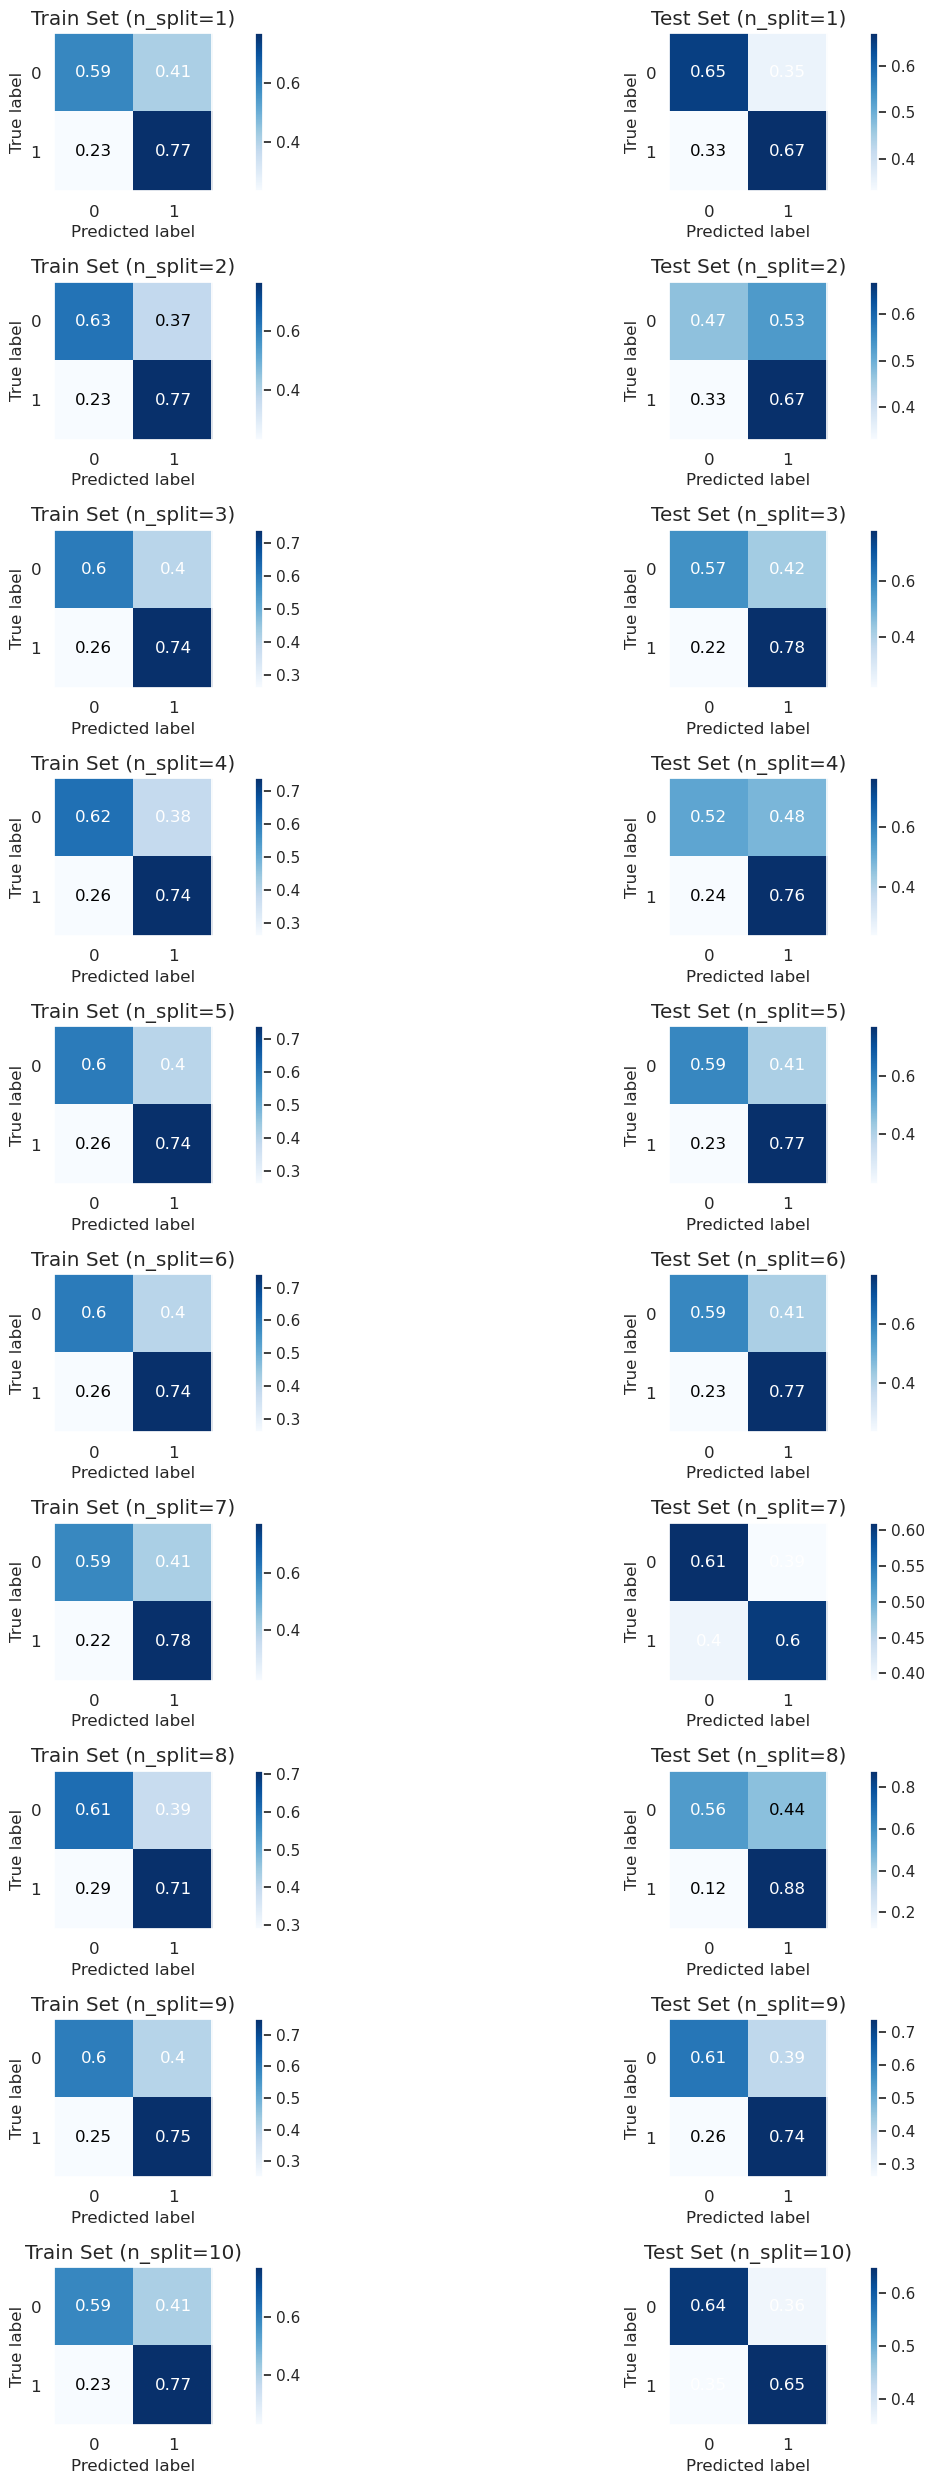

In [14]:
MyMultiTrainTester.plot_confusion(normalize=True, figsize=(15,25))

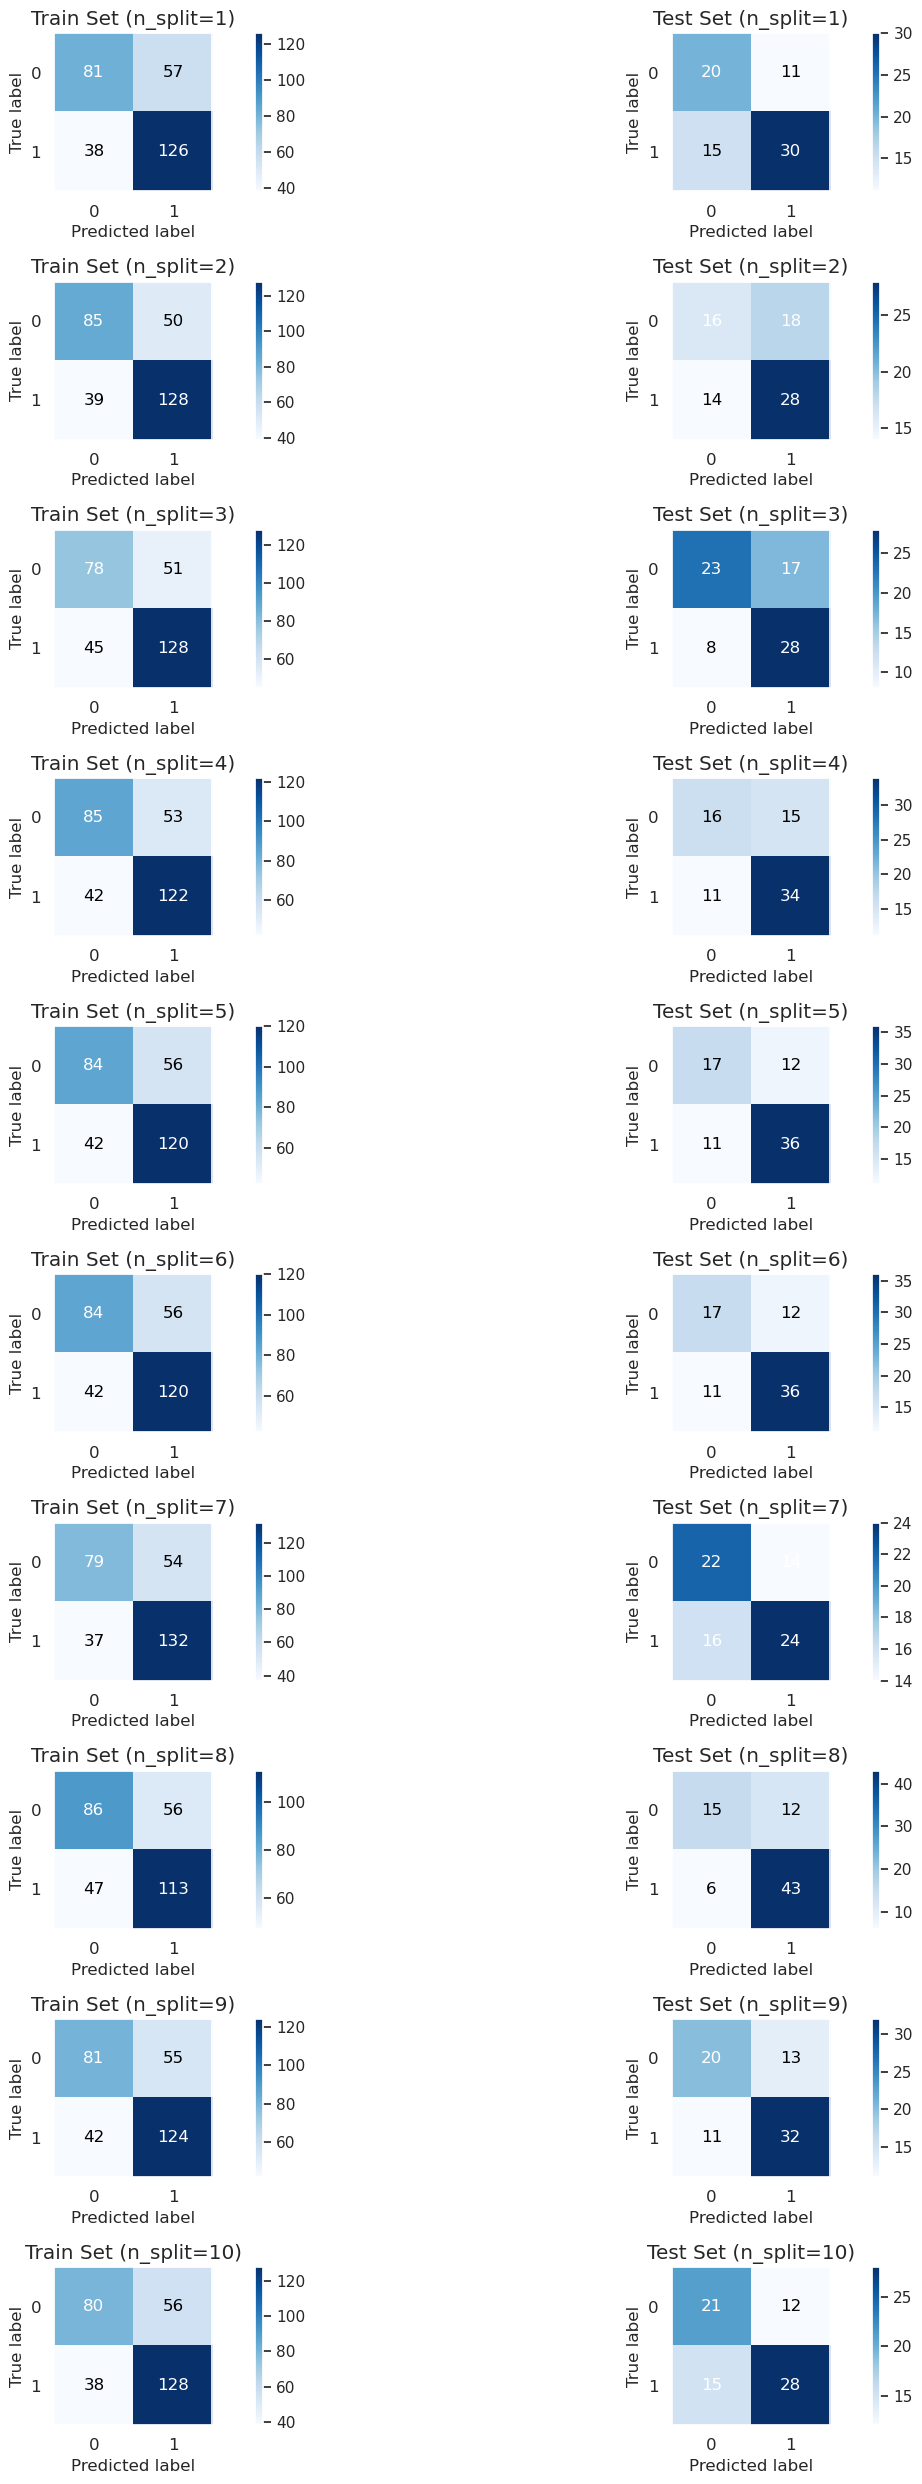

In [15]:
MyMultiTrainTester.plot_confusion(normalize=False, figsize=(15,25))

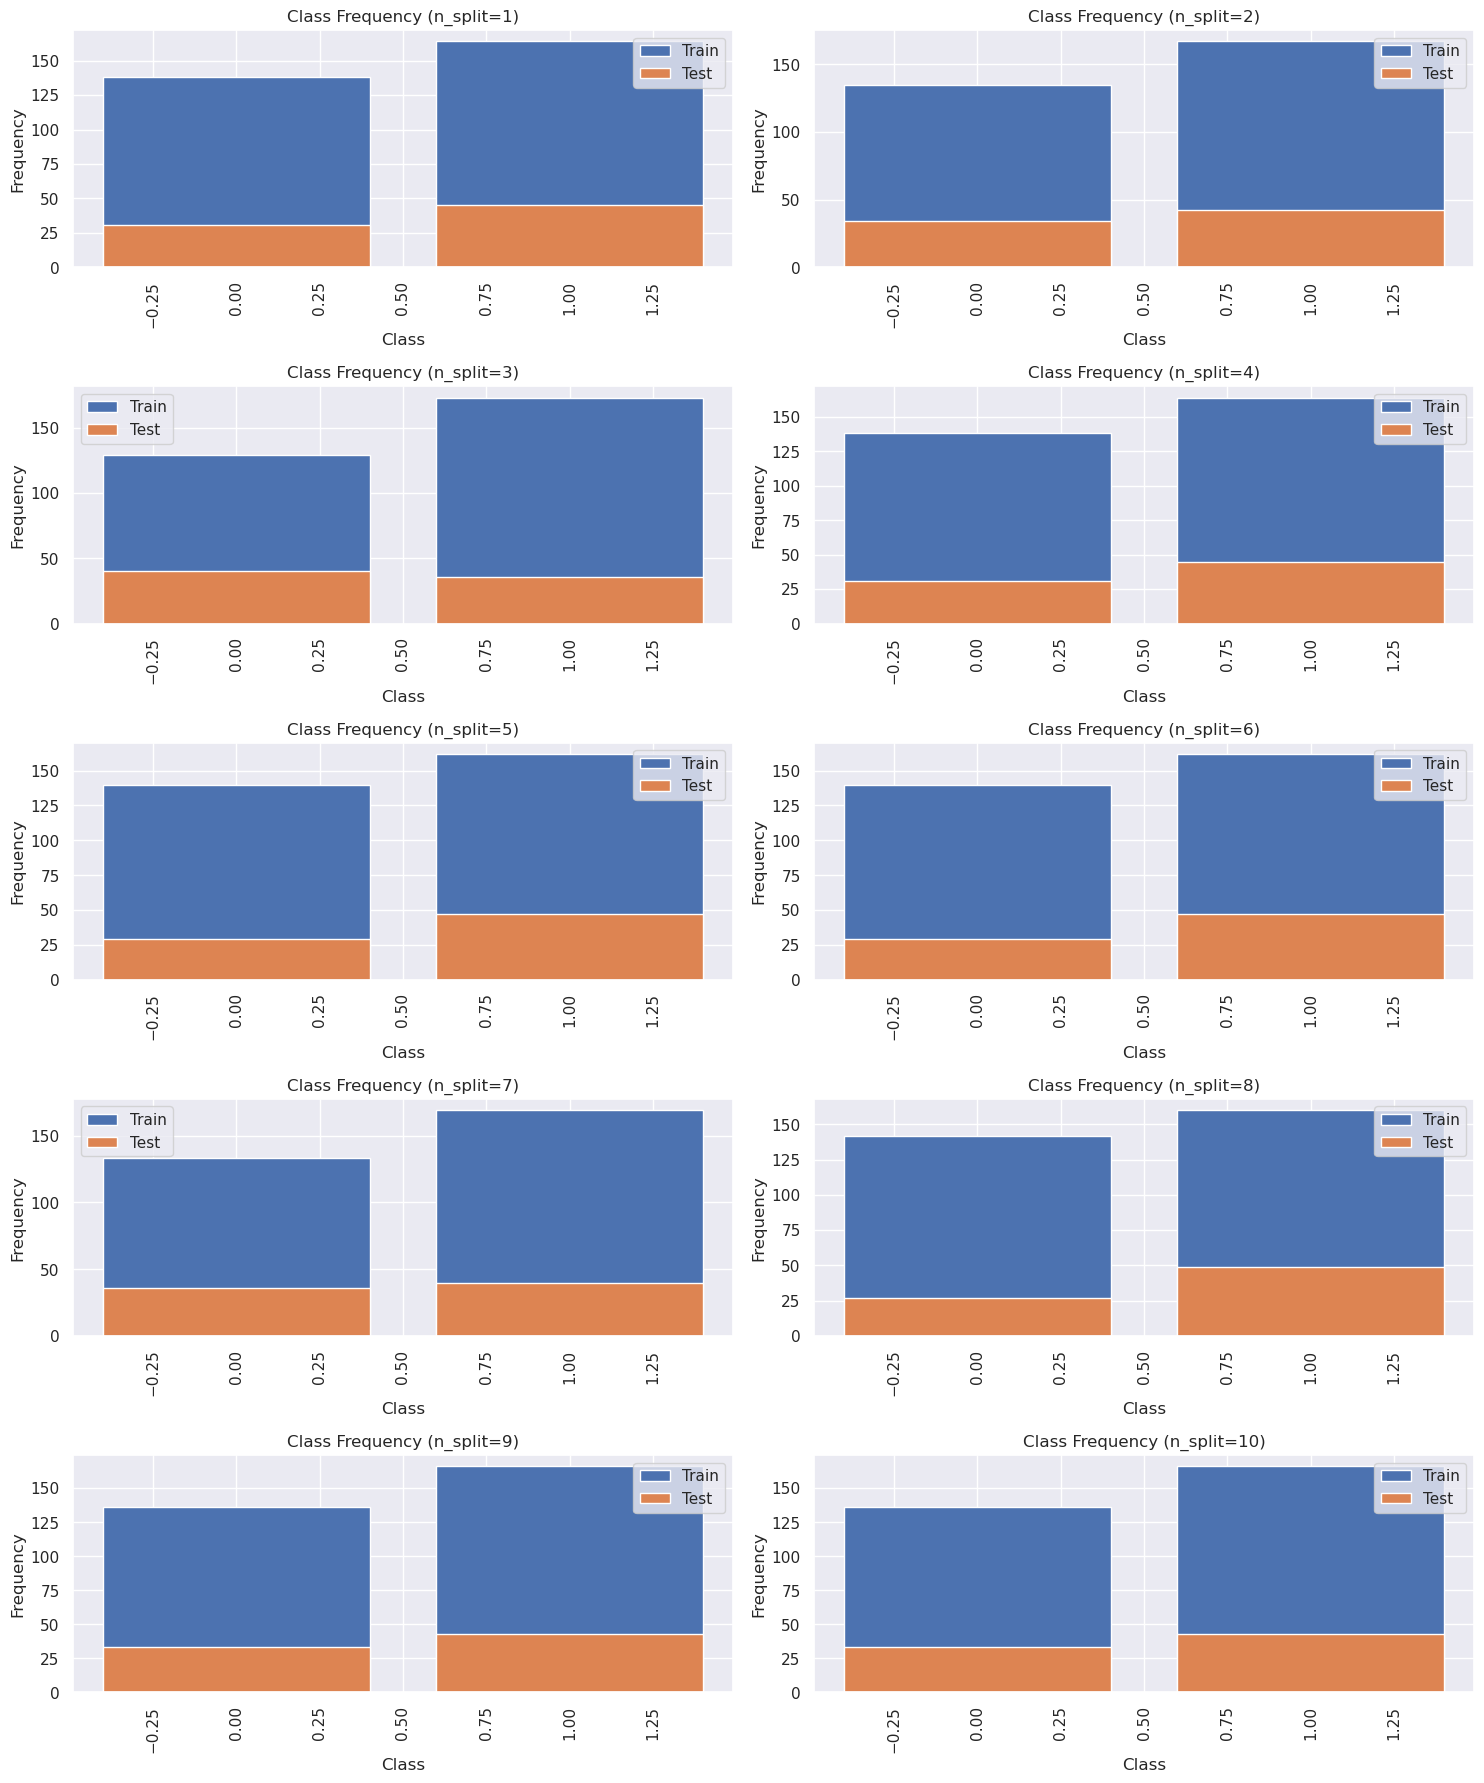

In [16]:
MyMultiTrainTester.plot_class_freq(normalize=True, figsize=(15,35))

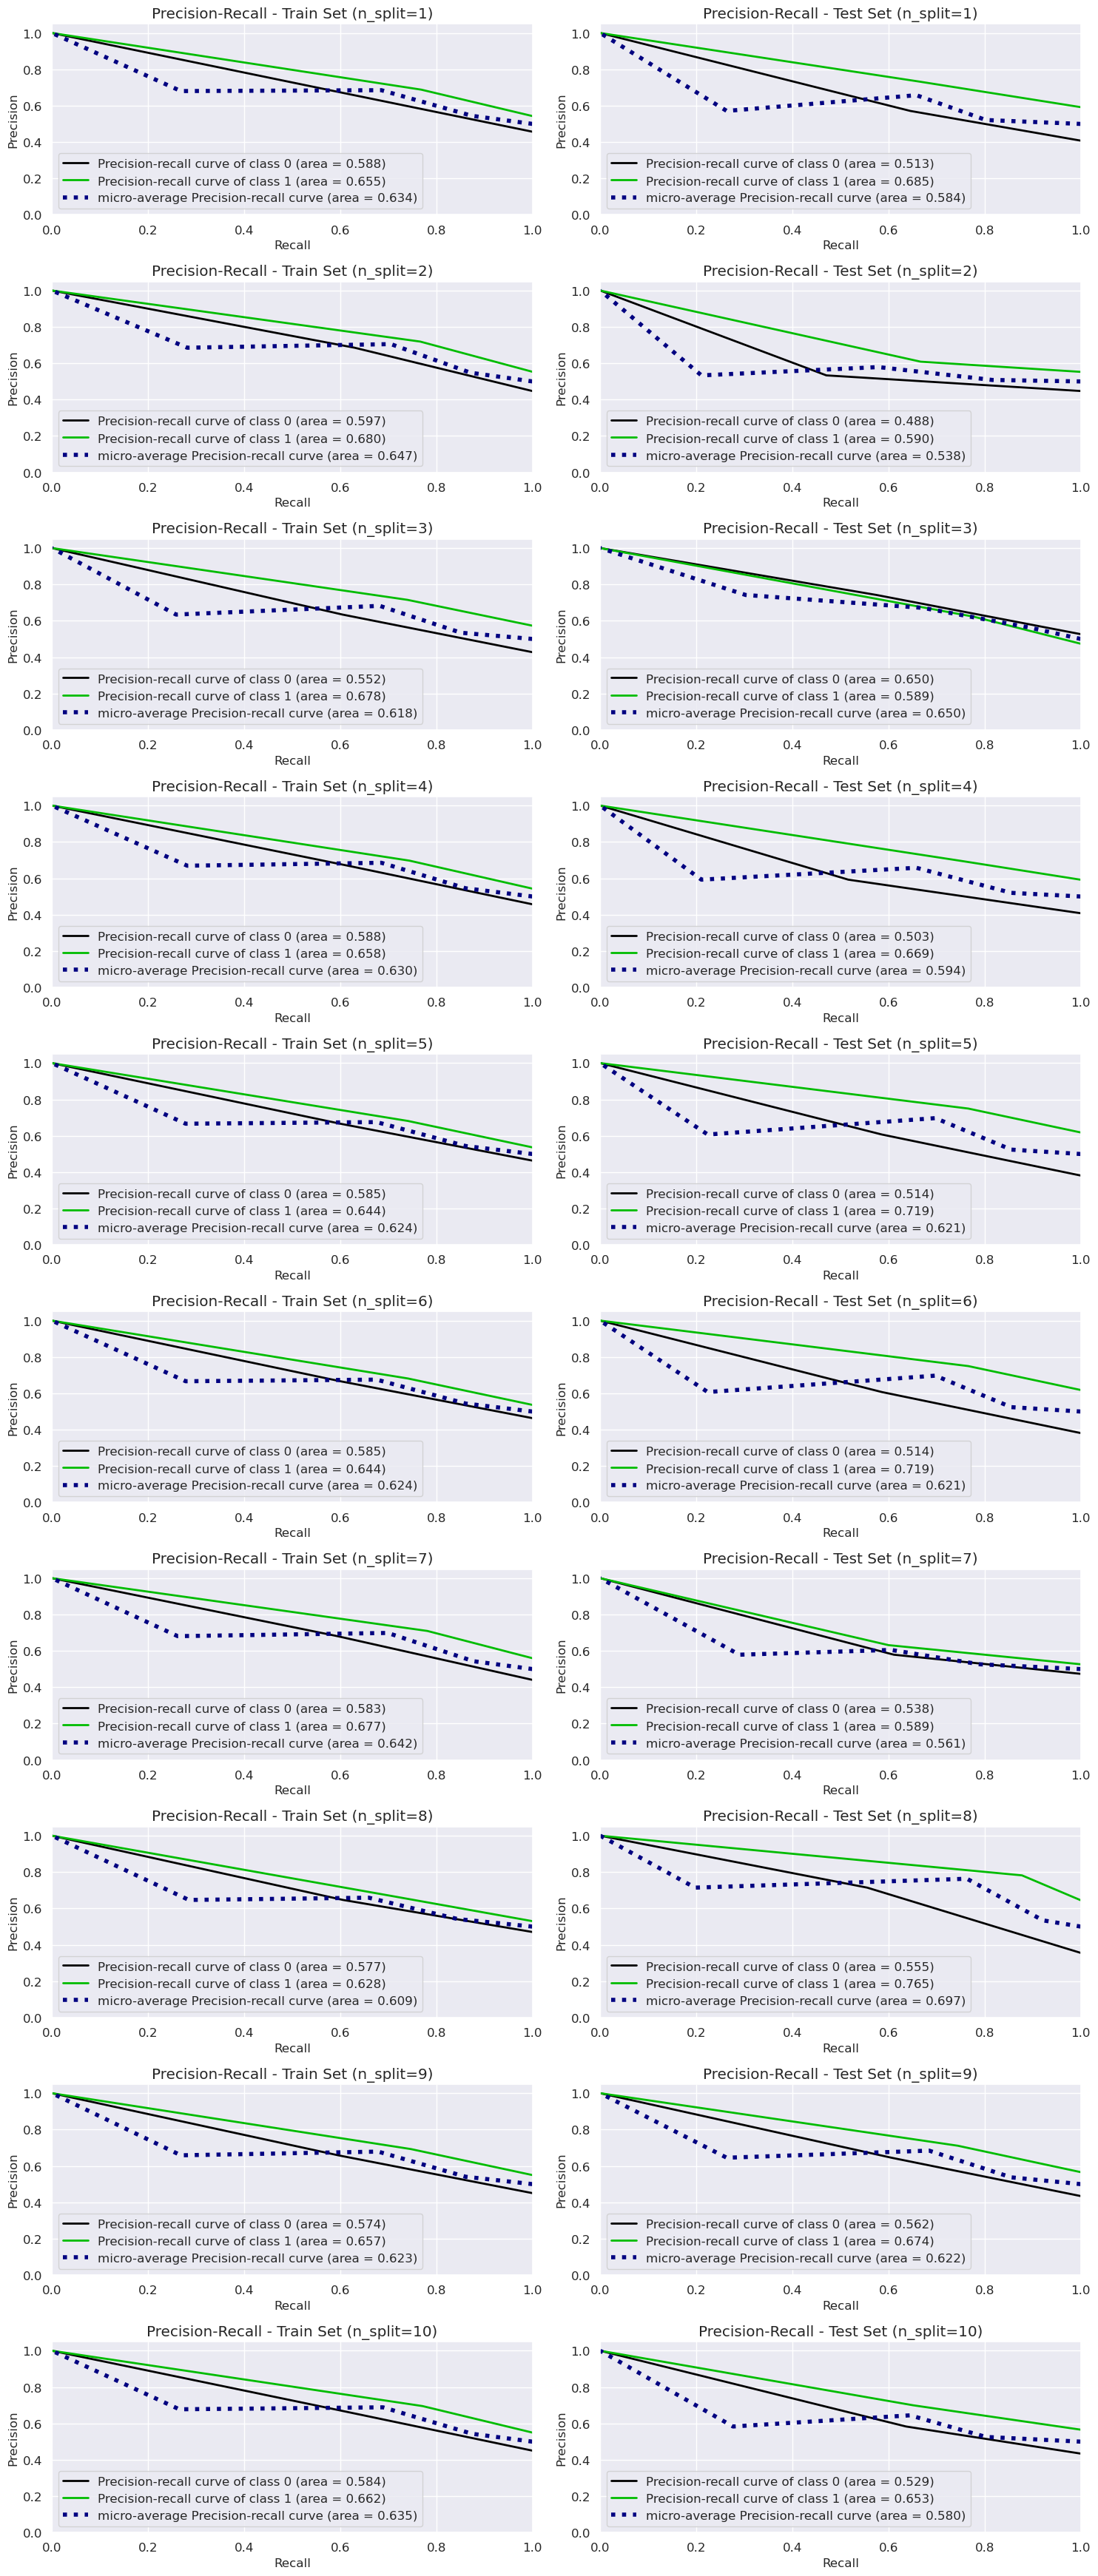

In [17]:
MyMultiTrainTester.plot_precrecall(figsize=(15,35))